In [1]:
import torch
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics

from torch import nn
from copy import deepcopy
from tqdm import tqdm

from bayes_opt import BayesianOptimization

In [10]:
# Use the following gym version.
# pip install gym==0.25.0
# pip install pygame

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# define global variable 
MAX_EP = 1
env = gym.make('CartPole-v1')

In [3]:
class Network(nn.Module):
    def __init__(self, env, learning_rate=0.01):
        super().__init__()

        in_features = int(np.prod(env.observation_space.shape))
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)

    def forward(self, x):
        return self.net(x)

    def act(self, state):
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = self.forward(state_t.unsqueeze(0))                           
        max_q_index = torch.argmax(q_values, dim=1)[0]                          
        action = max_q_index.detach().item()                                    
        return action   

In [4]:
def calculate_fitness(network, env, num_episodes=MAX_EP):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

In [5]:
def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    log_probs = []  # Store log probabilities of actions
    done = False
    while not done:
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = network(state_t.unsqueeze(0))
        action_probs = nn.functional.softmax(q_values, dim=1)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        log_probs.append(log_prob)
        state, reward, done, _ = env.step(action.item())
        total_reward += reward
    
    # Calculate loss based on the total reward
    loss = -total_reward * torch.stack(log_probs).sum()
    # Calculate gradients
    network.optimizer.zero_grad()
    loss.backward()
    # Update network parameters
    network.optimizer.step()

    return total_reward, log_probs

In [6]:
def mutate_and_tournament(population, tournament_size, mutation_rate, mutation_strength):
    
    # Select individuals for the tournament
    individuals = random.sample(population, tournament_size)
    # Calculate fitness for each individual
    fitnesses = [calculate_fitness(individual, env) for individual in individuals]
    # Select the best individual
    parent = individuals[np.argmax(fitnesses)]
    
    # Create offspring by deep copying the parent
    offspring = deepcopy(parent)
    
    # Return the mutated offspring
    return offspring

In [7]:
# Define genetic algorithm
def main(POPULATION_SIZE, GENERATIONS, ELITISM, TOURNAMENT_SIZE, MUTATION_STRENGTH, MUTATION_RATE):
    
    FITNESS_HISTORY = list()
    FITNESS_STDERROR_HISTORY = list()
    
    # Create initial population
    population = [Network(env) for _ in range(POPULATION_SIZE)]

    for generation in range(1, GENERATIONS + 1):

        # Calculate fitness for each network
        fitnesses = [calculate_fitness(network, env) for network in tqdm(population, desc="Calculating fitnesses")]
        
        # average fitness 
        avg_fitness = np.average(fitnesses)
        max_fitness = np.max(fitnesses)
        min_fitness = np.min(fitnesses)
        FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
        
        # std error
        standard_deviation = statistics.stdev(fitnesses)
        standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
        FITNESS_STDERROR_HISTORY.append(standard_error)

        print(f"[Generation: {generation}] \n Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")
        
        # Sort population by fitness
        population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
        
        # Select the best networks to pass their genes to the next generation
        survivors = population[:ELITISM]
        
        # Create the next generation
        next_population = survivors  # Start with the survivors
        
        num_individuals_to_add = POPULATION_SIZE - len(next_population)
        # Add offspring by tournament selection and mutation
        for _ in tqdm(range(num_individuals_to_add), desc="Generating Offspring"):
            offspring = mutate_and_tournament(population, TOURNAMENT_SIZE, MUTATION_RATE, MUTATION_STRENGTH)
            next_population.append(offspring)

        # The next generation becomes the current population
        population = next_population

    return population, FITNESS_HISTORY, FITNESS_STDERROR_HISTORY

### Version Control

In [8]:
# Version 1:
# Run the genetic algorithm
population, history, history_std = main(POPULATION_SIZE=200, 
                            GENERATIONS=100, 
                            ELITISM=100, 
                            TOURNAMENT_SIZE=3, 
                            MUTATION_STRENGTH=1, 
                            MUTATION_RATE=0.01)

Calculating fitnesses:   0%|                                      | 0/200 [00:00<?, ?it/s]/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:00<00:00, 403.60it/s]


[Generation: 1] 
 Average Fitness: 20.99 
 Best Fitness: 71.0 
 Worst Fitness: 8.0 
 Standard Error: 0.7827920008424425


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:00<00:00, 390.27it/s]


[Generation: 2] 
 Average Fitness: 22.33 
 Best Fitness: 87.0 
 Worst Fitness: 8.0 
 Standard Error: 0.8743729986130161


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:00<00:00, 342.21it/s]


[Generation: 3] 
 Average Fitness: 25.38 
 Best Fitness: 115.0 
 Worst Fitness: 8.0 
 Standard Error: 1.113678318449688


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:00<00:00, 267.90it/s]


[Generation: 4] 
 Average Fitness: 33.105 
 Best Fitness: 135.0 
 Worst Fitness: 9.0 
 Standard Error: 1.2931671513795249


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:00<00:00, 215.31it/s]


[Generation: 5] 
 Average Fitness: 41.64 
 Best Fitness: 138.0 
 Worst Fitness: 9.0 
 Standard Error: 1.5786108007680384


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:01<00:00, 188.32it/s]


[Generation: 6] 
 Average Fitness: 47.975 
 Best Fitness: 222.0 
 Worst Fitness: 14.0 
 Standard Error: 1.9116994662462587


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:01<00:00, 166.42it/s]


[Generation: 7] 
 Average Fitness: 53.15 
 Best Fitness: 185.0 
 Worst Fitness: 12.0 
 Standard Error: 2.1012648739156514


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:01<00:00, 149.35it/s]


[Generation: 8] 
 Average Fitness: 61.275 
 Best Fitness: 179.0 
 Worst Fitness: 11.0 
 Standard Error: 2.2476669925831403


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:01<00:00, 132.96it/s]


[Generation: 9] 
 Average Fitness: 65.53 
 Best Fitness: 271.0 
 Worst Fitness: 16.0 
 Standard Error: 2.67375961003627


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:01<00:00, 119.81it/s]


[Generation: 10] 
 Average Fitness: 70.065 
 Best Fitness: 284.0 
 Worst Fitness: 15.0 
 Standard Error: 2.804806333392592


Calculating fitnesses: 100%|███████████████████████████| 200/200 [00:01<00:00, 103.47it/s]


[Generation: 11] 
 Average Fitness: 87.275 
 Best Fitness: 268.0 
 Worst Fitness: 18.0 
 Standard Error: 3.348425997135289


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:02<00:00, 99.94it/s]


[Generation: 12] 
 Average Fitness: 91.71 
 Best Fitness: 307.0 
 Worst Fitness: 19.0 
 Standard Error: 3.407201875896933


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:02<00:00, 84.31it/s]


[Generation: 13] 
 Average Fitness: 107.335 
 Best Fitness: 283.0 
 Worst Fitness: 20.0 
 Standard Error: 3.9168895816674323


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:02<00:00, 70.13it/s]


[Generation: 14] 
 Average Fitness: 127.96 
 Best Fitness: 419.0 
 Worst Fitness: 13.0 
 Standard Error: 5.123592293493867


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:03<00:00, 55.43it/s]


[Generation: 15] 
 Average Fitness: 161.135 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 7.059035613592685


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:04<00:00, 48.04it/s]


[Generation: 16] 
 Average Fitness: 185.31 
 Best Fitness: 500.0 
 Worst Fitness: 24.0 
 Standard Error: 6.85296542935096


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:04<00:00, 42.77it/s]


[Generation: 17] 
 Average Fitness: 207.46 
 Best Fitness: 500.0 
 Worst Fitness: 41.0 
 Standard Error: 7.054314906067764


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:05<00:00, 36.16it/s]


[Generation: 18] 
 Average Fitness: 243.035 
 Best Fitness: 500.0 
 Worst Fitness: 52.0 
 Standard Error: 8.176471875857178


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:06<00:00, 32.31it/s]


[Generation: 19] 
 Average Fitness: 268.36 
 Best Fitness: 500.0 
 Worst Fitness: 71.0 
 Standard Error: 8.858068575850627


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:07<00:00, 27.00it/s]


[Generation: 20] 
 Average Fitness: 316.275 
 Best Fitness: 500.0 
 Worst Fitness: 57.0 
 Standard Error: 9.209709038720465


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:07<00:00, 25.77it/s]


[Generation: 21] 
 Average Fitness: 330.57 
 Best Fitness: 500.0 
 Worst Fitness: 42.0 
 Standard Error: 9.418773378726074


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:08<00:00, 22.82it/s]


[Generation: 22] 
 Average Fitness: 367.585 
 Best Fitness: 500.0 
 Worst Fitness: 51.0 
 Standard Error: 9.40320772142471


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:10<00:00, 19.54it/s]


[Generation: 23] 
 Average Fitness: 416.81 
 Best Fitness: 500.0 
 Worst Fitness: 65.0 
 Standard Error: 7.6401030998857875


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:10<00:00, 19.91it/s]


[Generation: 24] 
 Average Fitness: 407.365 
 Best Fitness: 500.0 
 Worst Fitness: 104.0 
 Standard Error: 8.460443510655036


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:10<00:00, 18.30it/s]


[Generation: 25] 
 Average Fitness: 450.98 
 Best Fitness: 500.0 
 Worst Fitness: 98.0 
 Standard Error: 6.658243690736029


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:10<00:00, 18.95it/s]


[Generation: 26] 
 Average Fitness: 438.37 
 Best Fitness: 500.0 
 Worst Fitness: 54.0 
 Standard Error: 6.993777959783522


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:10<00:00, 18.69it/s]


[Generation: 27] 
 Average Fitness: 443.19 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 7.37489422460557


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.70it/s]


[Generation: 28] 
 Average Fitness: 462.45 
 Best Fitness: 500.0 
 Worst Fitness: 40.0 
 Standard Error: 6.2691786146601824


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.64it/s]


[Generation: 29] 
 Average Fitness: 465.215 
 Best Fitness: 500.0 
 Worst Fitness: 107.0 
 Standard Error: 5.9732354367557425


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.29it/s]


[Generation: 30] 
 Average Fitness: 478.78 
 Best Fitness: 500.0 
 Worst Fitness: 82.0 
 Standard Error: 4.27319658396687


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.32it/s]


[Generation: 31] 
 Average Fitness: 475.525 
 Best Fitness: 500.0 
 Worst Fitness: 77.0 
 Standard Error: 5.376698925145269


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.18it/s]


[Generation: 32] 
 Average Fitness: 481.63 
 Best Fitness: 500.0 
 Worst Fitness: 148.0 
 Standard Error: 4.405183732671427


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.26it/s]


[Generation: 33] 
 Average Fitness: 478.0 
 Best Fitness: 500.0 
 Worst Fitness: 143.0 
 Standard Error: 4.437522736865807


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.45it/s]


[Generation: 34] 
 Average Fitness: 476.465 
 Best Fitness: 500.0 
 Worst Fitness: 109.0 
 Standard Error: 4.761586648593124


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.06it/s]


[Generation: 35] 
 Average Fitness: 484.215 
 Best Fitness: 500.0 
 Worst Fitness: 126.0 
 Standard Error: 3.926196501685727


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.79it/s]


[Generation: 36] 
 Average Fitness: 487.855 
 Best Fitness: 500.0 
 Worst Fitness: 155.0 
 Standard Error: 3.41925083260667


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.06it/s]


[Generation: 37] 
 Average Fitness: 477.965 
 Best Fitness: 500.0 
 Worst Fitness: 97.0 
 Standard Error: 5.030916365073246


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.91it/s]


[Generation: 38] 
 Average Fitness: 485.58 
 Best Fitness: 500.0 
 Worst Fitness: 70.0 
 Standard Error: 4.423488925198839


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.83it/s]


[Generation: 39] 
 Average Fitness: 485.34 
 Best Fitness: 500.0 
 Worst Fitness: 181.0 
 Standard Error: 3.6167911039272416


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.99it/s]


[Generation: 40] 
 Average Fitness: 477.215 
 Best Fitness: 500.0 
 Worst Fitness: 94.0 
 Standard Error: 4.646162719392787


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.35it/s]


[Generation: 41] 
 Average Fitness: 472.73 
 Best Fitness: 500.0 
 Worst Fitness: 123.0 
 Standard Error: 5.447897155516561


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.14it/s]


[Generation: 42] 
 Average Fitness: 481.335 
 Best Fitness: 500.0 
 Worst Fitness: 97.0 
 Standard Error: 4.5121849407685515


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.04it/s]


[Generation: 43] 
 Average Fitness: 479.205 
 Best Fitness: 500.0 
 Worst Fitness: 39.0 
 Standard Error: 5.082912044216998


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.13it/s]


[Generation: 44] 
 Average Fitness: 478.615 
 Best Fitness: 500.0 
 Worst Fitness: 77.0 
 Standard Error: 4.978202120925175


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.07it/s]


[Generation: 45] 
 Average Fitness: 481.79 
 Best Fitness: 500.0 
 Worst Fitness: 98.0 
 Standard Error: 4.314307097164412


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.31it/s]


[Generation: 46] 
 Average Fitness: 479.245 
 Best Fitness: 500.0 
 Worst Fitness: 97.0 
 Standard Error: 4.431712451328074


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.99it/s]


[Generation: 47] 
 Average Fitness: 485.91 
 Best Fitness: 500.0 
 Worst Fitness: 154.0 
 Standard Error: 3.785114922281009


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.34it/s]


[Generation: 48] 
 Average Fitness: 474.05 
 Best Fitness: 500.0 
 Worst Fitness: 31.0 
 Standard Error: 5.634164226632316


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.07it/s]


[Generation: 49] 
 Average Fitness: 484.05 
 Best Fitness: 500.0 
 Worst Fitness: 17.0 
 Standard Error: 4.164849017273426


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.19it/s]


[Generation: 50] 
 Average Fitness: 479.13 
 Best Fitness: 500.0 
 Worst Fitness: 66.0 
 Standard Error: 5.177164344819114


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.31it/s]


[Generation: 51] 
 Average Fitness: 480.965 
 Best Fitness: 500.0 
 Worst Fitness: 79.0 
 Standard Error: 4.468265418959729


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.00it/s]


[Generation: 52] 
 Average Fitness: 477.78 
 Best Fitness: 500.0 
 Worst Fitness: 18.0 
 Standard Error: 5.31108710445948


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.03it/s]


[Generation: 53] 
 Average Fitness: 480.16 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 5.385260173443656


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.06it/s]


[Generation: 54] 
 Average Fitness: 483.405 
 Best Fitness: 500.0 
 Worst Fitness: 38.0 
 Standard Error: 4.834481973776907


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.63it/s]


[Generation: 55] 
 Average Fitness: 467.035 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 6.445462653611102


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.21it/s]


[Generation: 56] 
 Average Fitness: 471.18 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 6.060767485439679


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.99it/s]


[Generation: 57] 
 Average Fitness: 487.685 
 Best Fitness: 500.0 
 Worst Fitness: 62.0 
 Standard Error: 3.9395978259399467


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.15it/s]


[Generation: 58] 
 Average Fitness: 489.625 
 Best Fitness: 500.0 
 Worst Fitness: 80.0 
 Standard Error: 3.3878695629966917


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.15it/s]


[Generation: 59] 
 Average Fitness: 481.855 
 Best Fitness: 500.0 
 Worst Fitness: 48.0 
 Standard Error: 4.987206736255351


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.17it/s]


[Generation: 60] 
 Average Fitness: 481.625 
 Best Fitness: 500.0 
 Worst Fitness: 144.0 
 Standard Error: 4.731384774505463


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.81it/s]


[Generation: 61] 
 Average Fitness: 482.565 
 Best Fitness: 500.0 
 Worst Fitness: 44.0 
 Standard Error: 4.467704195545457


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.38it/s]


[Generation: 62] 
 Average Fitness: 490.24 
 Best Fitness: 500.0 
 Worst Fitness: 19.0 
 Standard Error: 3.605329946079901


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.44it/s]


[Generation: 63] 
 Average Fitness: 491.745 
 Best Fitness: 500.0 
 Worst Fitness: 121.0 
 Standard Error: 3.495079078335581


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.02it/s]


[Generation: 64] 
 Average Fitness: 488.98 
 Best Fitness: 500.0 
 Worst Fitness: 58.0 
 Standard Error: 3.9493588309850236


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.20it/s]


[Generation: 65] 
 Average Fitness: 484.46 
 Best Fitness: 500.0 
 Worst Fitness: 63.0 
 Standard Error: 4.495915734470263


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.14it/s]


[Generation: 66] 
 Average Fitness: 485.585 
 Best Fitness: 500.0 
 Worst Fitness: 63.0 
 Standard Error: 4.066552362330761


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.47it/s]


[Generation: 67] 
 Average Fitness: 490.97 
 Best Fitness: 500.0 
 Worst Fitness: 253.0 
 Standard Error: 2.9171552019667737


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.98it/s]


[Generation: 68] 
 Average Fitness: 485.145 
 Best Fitness: 500.0 
 Worst Fitness: 48.0 
 Standard Error: 4.490992646369925


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.56it/s]


[Generation: 69] 
 Average Fitness: 487.91 
 Best Fitness: 500.0 
 Worst Fitness: 78.0 
 Standard Error: 3.7146808434701657


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.01it/s]


[Generation: 70] 
 Average Fitness: 487.965 
 Best Fitness: 500.0 
 Worst Fitness: 46.0 
 Standard Error: 3.7014690652774647


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.49it/s]


[Generation: 71] 
 Average Fitness: 477.075 
 Best Fitness: 500.0 
 Worst Fitness: 45.0 
 Standard Error: 5.151313134536694


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.00it/s]


[Generation: 72] 
 Average Fitness: 486.78 
 Best Fitness: 500.0 
 Worst Fitness: 144.0 
 Standard Error: 3.8306825296826776


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.45it/s]


[Generation: 73] 
 Average Fitness: 483.97 
 Best Fitness: 500.0 
 Worst Fitness: 35.0 
 Standard Error: 4.762183053725038


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.51it/s]


[Generation: 74] 
 Average Fitness: 479.77 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 5.362468259033869


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.90it/s]


[Generation: 75] 
 Average Fitness: 487.515 
 Best Fitness: 500.0 
 Worst Fitness: 36.0 
 Standard Error: 3.970949644657057


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.35it/s]


[Generation: 76] 
 Average Fitness: 482.325 
 Best Fitness: 500.0 
 Worst Fitness: 17.0 
 Standard Error: 5.734178308999206


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.25it/s]


[Generation: 77] 
 Average Fitness: 482.55 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 5.367966357389952


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.87it/s]


[Generation: 78] 
 Average Fitness: 486.83 
 Best Fitness: 500.0 
 Worst Fitness: 18.0 
 Standard Error: 3.992695025648615


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.56it/s]


[Generation: 79] 
 Average Fitness: 482.695 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 4.959718126514083


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.32it/s]


[Generation: 80] 
 Average Fitness: 487.82 
 Best Fitness: 500.0 
 Worst Fitness: 67.0 
 Standard Error: 4.0443381852639275


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.77it/s]


[Generation: 81] 
 Average Fitness: 486.47 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 4.775470773183272


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.55it/s]


[Generation: 82] 
 Average Fitness: 487.18 
 Best Fitness: 500.0 
 Worst Fitness: 15.0 
 Standard Error: 4.657995557432974


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.20it/s]


[Generation: 83] 
 Average Fitness: 475.96 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 6.541728599179779


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.57it/s]


[Generation: 84] 
 Average Fitness: 492.64 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 3.6335472099084063


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.66it/s]


[Generation: 85] 
 Average Fitness: 492.59 
 Best Fitness: 500.0 
 Worst Fitness: 50.0 
 Standard Error: 3.141113252067101


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.72it/s]


[Generation: 86] 
 Average Fitness: 489.355 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 4.382668569943414


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.88it/s]


[Generation: 87] 
 Average Fitness: 490.78 
 Best Fitness: 500.0 
 Worst Fitness: 208.0 
 Standard Error: 3.2193132636398145


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.83it/s]


[Generation: 88] 
 Average Fitness: 491.085 
 Best Fitness: 500.0 
 Worst Fitness: 42.0 
 Standard Error: 3.675026253623791


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.77it/s]


[Generation: 89] 
 Average Fitness: 492.54 
 Best Fitness: 500.0 
 Worst Fitness: 88.0 
 Standard Error: 3.0237073320926338


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.53it/s]


[Generation: 90] 
 Average Fitness: 496.22 
 Best Fitness: 500.0 
 Worst Fitness: 278.0 
 Standard Error: 1.5602982577912248


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.54it/s]


[Generation: 91] 
 Average Fitness: 491.05 
 Best Fitness: 500.0 
 Worst Fitness: 32.0 
 Standard Error: 3.660420864398329


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.95it/s]


[Generation: 92] 
 Average Fitness: 488.29 
 Best Fitness: 500.0 
 Worst Fitness: 20.0 
 Standard Error: 4.7014089088956315


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.88it/s]


[Generation: 93] 
 Average Fitness: 494.395 
 Best Fitness: 500.0 
 Worst Fitness: 259.0 
 Standard Error: 2.2158168009737147


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.69it/s]


[Generation: 94] 
 Average Fitness: 493.98 
 Best Fitness: 500.0 
 Worst Fitness: 164.0 
 Standard Error: 2.789850232827569


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.53it/s]


[Generation: 95] 
 Average Fitness: 493.31 
 Best Fitness: 500.0 
 Worst Fitness: 47.0 
 Standard Error: 2.889787858882851


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.50it/s]


[Generation: 96] 
 Average Fitness: 490.365 
 Best Fitness: 500.0 
 Worst Fitness: 13.0 
 Standard Error: 3.8625711845581425


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 17.08it/s]


[Generation: 97] 
 Average Fitness: 488.535 
 Best Fitness: 500.0 
 Worst Fitness: 14.0 
 Standard Error: 4.805863658335779


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 16.55it/s]


[Generation: 98] 
 Average Fitness: 480.785 
 Best Fitness: 500.0 
 Worst Fitness: 12.0 
 Standard Error: 5.927857229358539


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:12<00:00, 15.88it/s]


[Generation: 99] 
 Average Fitness: 485.93 
 Best Fitness: 500.0 
 Worst Fitness: 16.0 
 Standard Error: 4.622571398221805


Calculating fitnesses: 100%|████████████████████████████| 200/200 [00:11<00:00, 16.67it/s]


[Generation: 100] 
 Average Fitness: 488.645 
 Best Fitness: 500.0 
 Worst Fitness: 10.0 
 Standard Error: 4.186019430000499


Generating Offspring: 100%|█████████████████████████████| 100/100 [00:17<00:00,  5.64it/s]


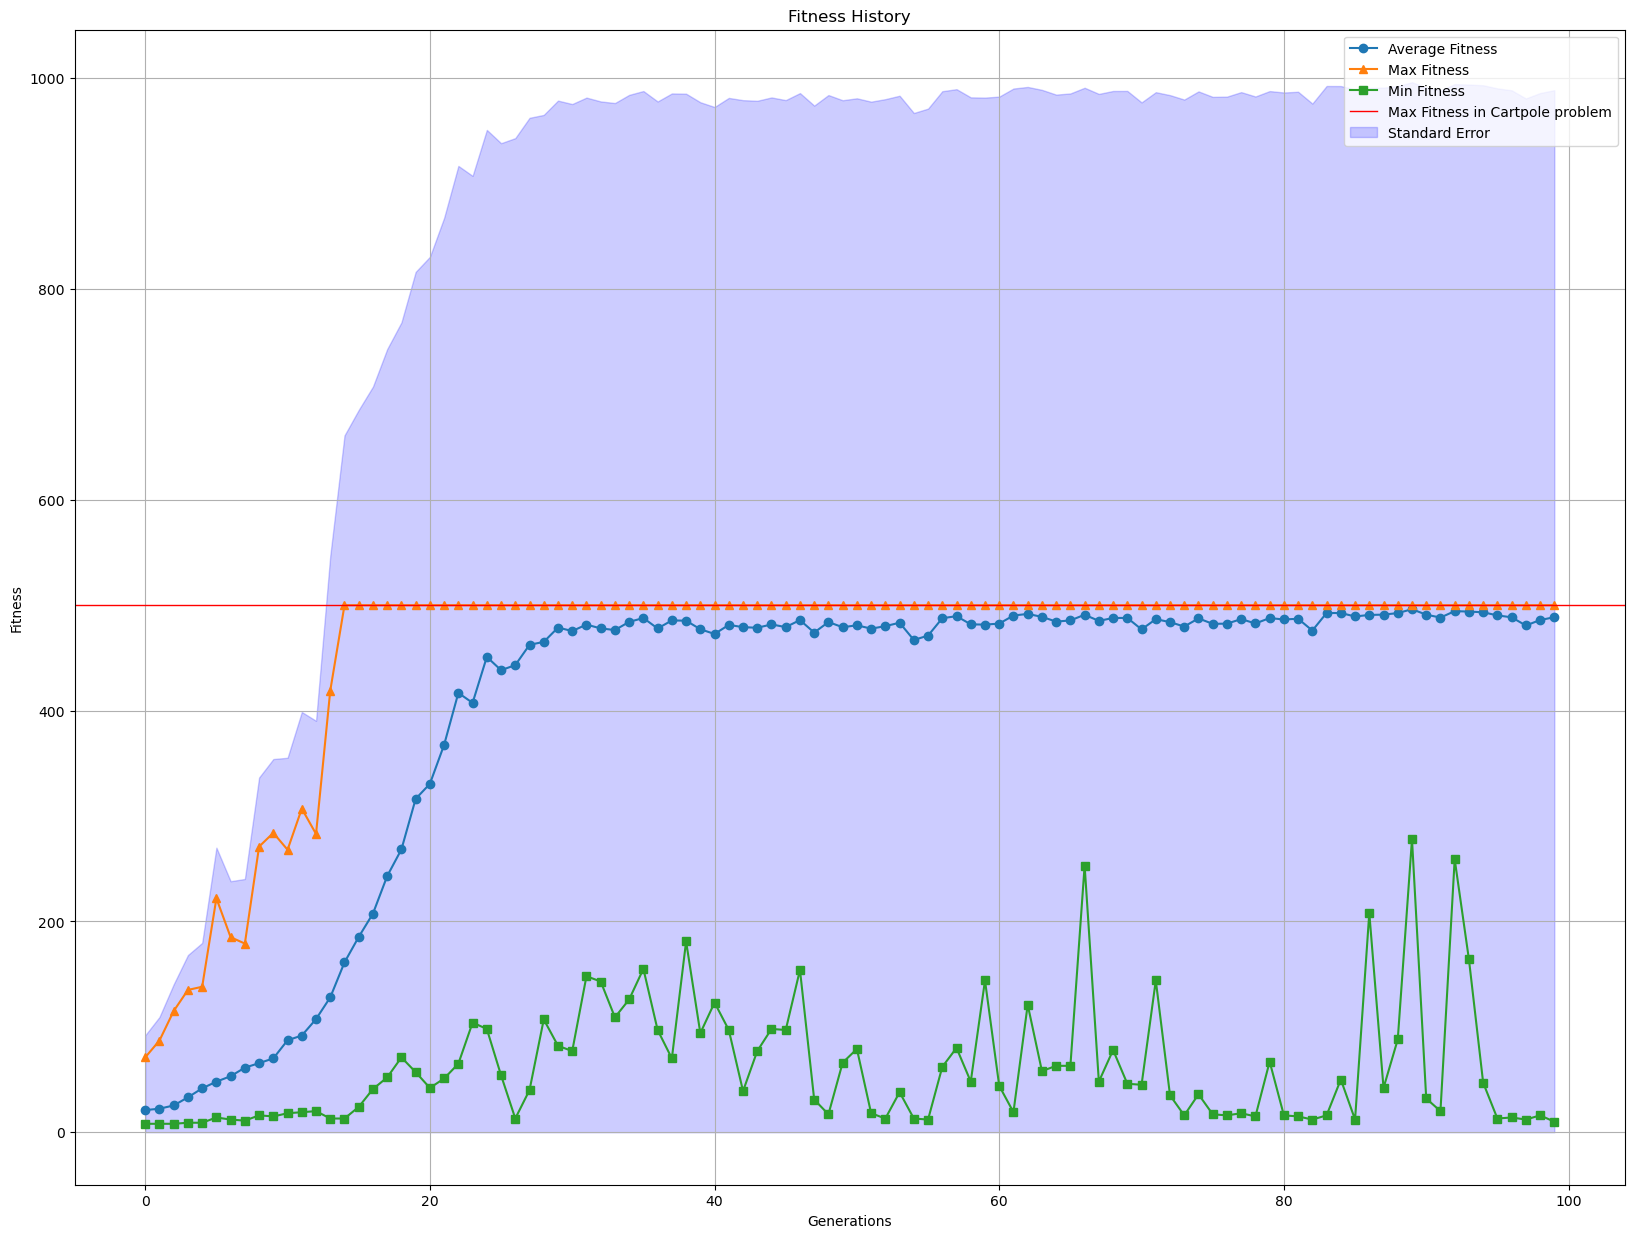

In [9]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(100), np.array(history)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(100), np.array(history)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(100), np.array(history)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.axhline(y=500, color='r', linewidth=1, label='Max Fitness in Cartpole problem')
plt.fill_between(np.arange(100), 0, np.array(history)[:,0] + np.array(history)[:,1],
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()